In [1]:
import PRF
from sklearn.ensemble import RandomForestClassifier
import numpy

In [2]:
import numpy
X = numpy.load('data/bootstrap_X.npy')
y = numpy.load('data/bootstrap_y.npy')
print(X)
print(y)
print(numpy.mean(y))
print(numpy.std(y))
y[y > 2] = 2
print(y)

n_objects = X.shape[0]
n_features = X.shape[1]
print(n_objects, 'objects,', n_features, 'features')

shuffled_inds = numpy.random.choice(numpy.arange(n_objects),n_objects,replace=False)
print("Shuffled Indices: ", shuffled_inds)
print(len(shuffled_inds))
shuffled_inds = numpy.where( (y == 1)  |  (y == 2) |  (y == 4)|  (y == 5)|  (y == 6)|  (y == 8)|  (y == 13))[0]
print("Y Cut Shuffled Indices: ", shuffled_inds)
print(len(shuffled_inds))
shuffled_inds = numpy.random.choice(shuffled_inds,len(shuffled_inds),replace=False)
print("Re-Shuffled Indices? ", shuffled_inds)
n_train = 5000
n_test = 500
print('Train set size = {}, Test set size = {}'.format(n_train, n_test))

nf = n_features
train_inds = shuffled_inds[:n_train]
X_train = X[train_inds][:,:nf]
y_train = y[train_inds]

test_inds = shuffled_inds[n_train:(n_train + n_test)]
X_test = X[test_inds][:,:nf]
y_test = y[test_inds]

[[ 0.33453338  0.3817734   0.19323093 ... -0.81191589  0.19067206
   0.84772759]
 [ 0.32742773  0.35012285  0.17785153 ... -0.85643206  0.19620735
   0.85023905]
 [ 0.39173798  0.32019704  0.17513842 ...  0.23618577  0.20204299
   0.79843681]
 ...
 [ 0.403697    0.27038462  0.12964029 ...  0.89465122  0.1941173
   0.77770493]
 [ 0.25029907  0.33824084  0.20026945 ...  0.8638979   0.14645717
   0.82934586]
 [ 0.27610644  0.34        0.16186233 ... -0.52845195  0.15704813
   0.83015366]]
[5 1 4 ... 1 5 1]
2.34630222977833
2.584966902039068
[2 1 2 ... 1 2 1]
45879 objects, 17 features
Shuffled Indices:  [27468  5396 35251 ... 30188 14642 30824]
45879
Y Cut Shuffled Indices:  [    0     1     2 ... 45876 45877 45878]
45879
Re-Shuffled Indices?  [23437 39227 16792 ... 25032 37931 42243]
Train set size = 5000, Test set size = 500


In [13]:
n_trees = 10
prf_cls = PRF.prf(n_estimators=n_trees,  bootstrap=True)
prf_cls.fit(X=X_train, y=y_train)
prf_cls.score(X_test, y=y_test)

0.794

# Missing values
* the original data does not have missing values. We add missing values to the data by setting in random elements in X to numpy.nan
* we compare the results to the original RF where the missing values are imputed

In [4]:
from sklearn.impute import SimpleImputer as Imputer # for new versions for sklearn
#from sklearn.preprocessing import Imputer # old versions of sklearn

import matplotlib.pyplot as plt

def insert_nans(X_train, X_test, nan_frac):
    X_train_w_nans = X_train.copy()
    X_test_w_nans = X_test.copy()

    nof_nans = int( numpy.prod(X_train.shape) * nan_frac )
    for i in range(nof_nans):
        o = numpy.random.choice(n_train)
        f = numpy.random.choice(nf)
        X_train_w_nans[o,f] = numpy.nan

    nof_nans = int( numpy.prod(X_test.shape) * nan_frac )
    for i in range(nof_nans):
        o = numpy.random.choice(n_test)
        f = numpy.random.choice(nf)
        X_test_w_nans[o,f] = numpy.nan
    
    imp = Imputer(missing_values=numpy.nan, strategy='median')
    X_train_w_nans_imp = imp.fit_transform(X_train_w_nans)
    X_test_w_nans_imp = imp.fit_transform(X_test_w_nans)
    
    return X_train_w_nans, X_test_w_nans, X_train_w_nans_imp, X_test_w_nans_imp

def prf_rf_nans_compare_single(X_train, X_test, n_trees, nan_frac):
    
    X_train_w_nans, X_test_w_nans, X_train_w_nans_imp, X_test_w_nans_imp = insert_nans(X_train, X_test, nan_frac)

    nof_nans = numpy.sum(numpy.isnan(X_train_w_nans))
    print('fraction of nans in X: {:.3f}'.format(nof_nans/numpy.prod(X_train.shape)))
    
    print('Accuracy for {} trees --- '.format(n_trees))

    prf_cls = PRF.prf(n_estimators=n_trees,  bootstrap=True)
    prf_cls.fit(X=X_train_w_nans, y=y_train)
    print('PRF: {}'.format(prf_cls.score(X=X_test_w_nans, y=y_test)))

    RF = RandomForestClassifier(n_estimators=n_trees,n_jobs=-1, bootstrap=True)
    RF.fit(X_train, y_train)
    print('RF: {}'.format(RF.score(X_test_w_nans_imp,y_test)))
    
    return

def plot_prf_rf_cmpr(nan_frac_vec_true, prf_scores, prf_scores_stds, rf_scores, rf_scores_stds):
    plt.figure(figsize = (10,7))
    lw = 7
    alpha = 0.5
    alpha_eb = 0.3
    ms = 25
    
    markers, caps, bars =plt.errorbar(x=nan_frac_vec_true,y=prf_scores,yerr=prf_scores_stds,capsize=10, label = 'PRF',fmt ='--*', markersize= 15, capthick=3)
    [bar.set_alpha(alpha_eb) for bar in bars]
    markers, caps, bars =plt.errorbar(x=nan_frac_vec_true,y=rf_scores,yerr=rf_scores_stds,capsize=10,label = 'RF',fmt ='--*', markersize= 15, capthick=3)
    [bar.set_alpha(alpha_eb) for bar in bars]

    plt.legend(fontsize = 20)
    plt.xlabel('Fraction of NaNs in X', fontsize = 20)
    plt.ylabel('Accuracy', fontsize = 20)
    plt.xticks(fontsize = 20)
    yticks = plt.gca().get_yticks()
    yticks_p = ['{}%'.format('%.1f' % (yt*100)) for yt in yticks]
    plt.yticks(yticks, yticks_p, fontsize = 20)
    plt.tight_layout()
    plt.show()
    
    return

def prf_rf_nans_compare_full(X_train, X_test, n_itr, n_trees):

    nof_elements = numpy.prod(X_train.shape)
    
    prf_scores = []
    prf_scores_stds = []
    rf_scores = []
    rf_scores_stds = []

    nan_frac_vec = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.1, 1.5, 2]
    nan_frac_vec_true = numpy.zeros(len(nan_frac_vec))
    for n_idx, nan_frac in enumerate(nan_frac_vec):

        X_train_w_nans, X_test_w_nans, X_train_w_nans_imp, X_test_w_nans_imp = insert_nans(X_train, X_test, nan_frac)

        scores = numpy.zeros(n_itr)
        for i in range(n_itr): 
            prf_cls = PRF.prf(n_estimators=n_trees,  bootstrap=True, keep_proba=0.01)
            prf_cls.fit(X=X_train_w_nans, y=y_train)
            scores[i] = prf_cls.score(X=X_test_w_nans, y=y_test)
        prf_scores += [scores.mean()]
        prf_scores_stds += [scores.std()]

        scores = numpy.zeros(n_itr)
        for i in range(n_itr): 
            RF = RandomForestClassifier(n_estimators=n_trees,n_jobs=-1, bootstrap=True)
            RF.fit(X_train_w_nans_imp, y_train)
            scores[i] = RF.score(X_test_w_nans_imp,y_test)
        rf_scores += [scores.mean()]
        rf_scores_stds += [scores.std()]
        
        nof_nans = numpy.sum(numpy.isnan(X_train_w_nans))
        nan_frac_vec_true[n_idx] = nof_nans/nof_elements

        print('nan fraction:{:.2f}, PRF:{:.3f}, RF:{:.3f}'.format(nan_frac_vec_true[n_idx],prf_scores[-1], rf_scores[-1]))
        

    
    plot_prf_rf_cmpr(nan_frac_vec_true, prf_scores, prf_scores_stds, rf_scores, rf_scores_stds)
    
    return nan_frac_vec_true, prf_scores, rf_scores, prf_scores_stds, rf_scores_stds


def prf_rf_nans_test_set_only_compare_full(X_train, X_test, n_itr, n_trees):

    nof_elements = numpy.prod(X_train.shape)
    
    prf_scores = []
    prf_scores_stds = []
    rf_scores = []
    rf_scores_stds = []

    nan_frac_vec = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.1, 1.5, 2]
    nan_frac_vec_true = numpy.zeros(len(nan_frac_vec))
    for n_idx, nan_frac in enumerate(nan_frac_vec):

        X_train_w_nans, X_test_w_nans, X_train_w_nans_imp, X_test_w_nans_imp = insert_nans(X_train, X_test, nan_frac)

        scores = numpy.zeros(n_itr)
        for i in range(n_itr): 
            prf_cls = PRF.prf(n_estimators=n_trees,  bootstrap=True, keep_proba=0.01)
            prf_cls.fit(X=X_train, y=y_train)
            scores[i] = prf_cls.score(X=X_test_w_nans, y=y_test)
        prf_scores += [scores.mean()]
        prf_scores_stds += [scores.std()]

        scores = numpy.zeros(n_itr)
        for i in range(n_itr): 
            RF = RandomForestClassifier(n_estimators=n_trees,n_jobs=-1, bootstrap=True)
            RF.fit(X_train, y_train)
            scores[i] = RF.score(X_test_w_nans_imp,y_test)
        rf_scores += [scores.mean()]
        rf_scores_stds += [scores.std()]
        
        nof_nans = numpy.sum(numpy.isnan(X_train_w_nans))
        nan_frac_vec_true[n_idx] = nof_nans/nof_elements

        print('nan fraction:{:.2f}, PRF:{:.3f}, RF:{:.3f}'.format(nan_frac_vec_true[n_idx],prf_scores[-1], rf_scores[-1]))
        

    plot_prf_rf_cmpr(nan_frac_vec_true, prf_scores, prf_scores_stds, rf_scores, rf_scores_stds)
    
    return nan_frac_vec_true, prf_scores, rf_scores, prf_scores_stds, rf_scores_stds

In [5]:
_ = prf_rf_nans_compare_single(X_train=X_train, X_test=X_test, n_trees=1, nan_frac=0.5)

fraction of nans in X: 0.393
Accuracy for 1 trees --- 
PRF: 0.716
RF: 0.604


In [6]:
_ = prf_rf_nans_compare_single(X_train=X_train, X_test=X_test, n_trees=10, nan_frac=0.5)

fraction of nans in X: 0.394
Accuracy for 10 trees --- 
PRF: 0.77
RF: 0.702


In [7]:
_ = prf_rf_nans_compare_single(X_train=X_train, X_test=X_test, n_trees=100, nan_frac=0.5)

fraction of nans in X: 0.393
Accuracy for 100 trees --- 
PRF: 0.754
RF: 0.716


# Missing values in both train and test sets
* The PRF accuracy is higher for a single tree, but the same as a regular RF for a large number of trees

nan fraction:0.00, PRF:0.720, RF:0.720
nan fraction:0.05, PRF:0.734, RF:0.708
nan fraction:0.10, PRF:0.739, RF:0.698
nan fraction:0.18, PRF:0.734, RF:0.686
nan fraction:0.26, PRF:0.739, RF:0.667
nan fraction:0.33, PRF:0.748, RF:0.671
nan fraction:0.39, PRF:0.730, RF:0.664
nan fraction:0.45, PRF:0.725, RF:0.667
nan fraction:0.55, PRF:0.721, RF:0.644
nan fraction:0.67, PRF:0.715, RF:0.613
nan fraction:0.78, PRF:0.684, RF:0.602
nan fraction:0.87, PRF:0.662, RF:0.553


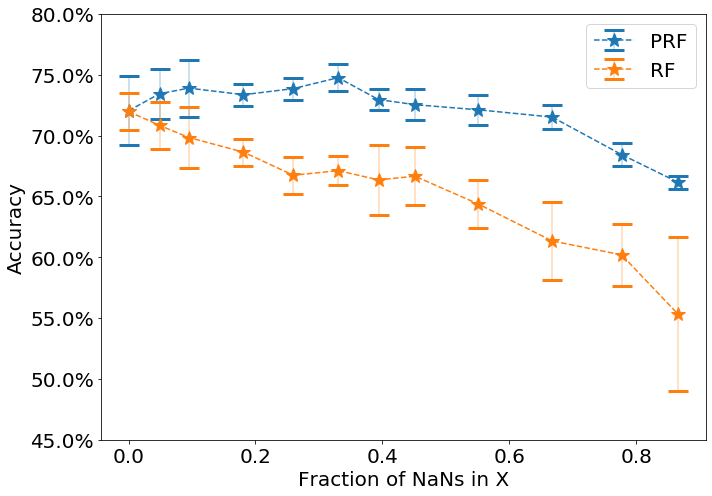

In [8]:
_ = prf_rf_nans_compare_full(X_train=X_train, X_test=X_test, n_itr=10, n_trees=1)

nan fraction:0.00, PRF:0.800, RF:0.822
nan fraction:0.05, PRF:0.808, RF:0.780
nan fraction:0.10, PRF:0.784, RF:0.796
nan fraction:0.18, PRF:0.790, RF:0.778
nan fraction:0.26, PRF:0.788, RF:0.778
nan fraction:0.33, PRF:0.756, RF:0.770
nan fraction:0.39, PRF:0.758, RF:0.764
nan fraction:0.45, PRF:0.760, RF:0.774
nan fraction:0.55, PRF:0.734, RF:0.724
nan fraction:0.67, PRF:0.708, RF:0.696
nan fraction:0.78, PRF:0.736, RF:0.704
nan fraction:0.87, PRF:0.674, RF:0.632


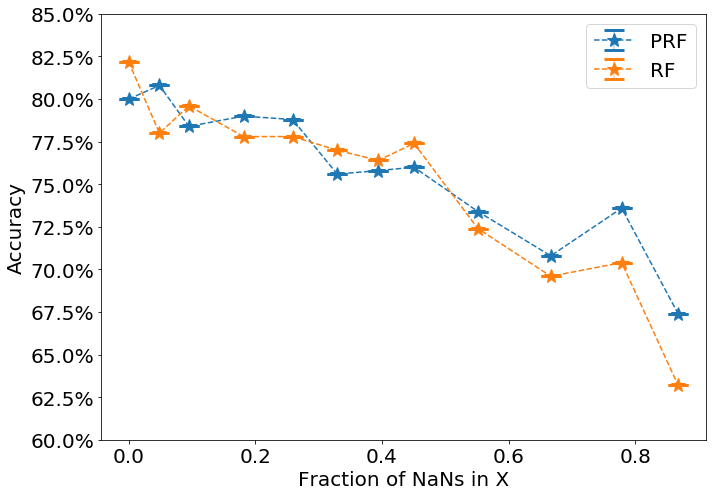

In [9]:
_ = prf_rf_nans_compare_full(X_train=X_train, X_test=X_test, n_itr = 1, n_trees = 25)

# Missing values in test set only
* The PRF accuracy is higher even for a large number of trees

nan fraction:0.00, PRF:0.720, RF:0.725
nan fraction:0.05, PRF:0.730, RF:0.703
nan fraction:0.10, PRF:0.707, RF:0.694
nan fraction:0.18, PRF:0.719, RF:0.677
nan fraction:0.26, PRF:0.728, RF:0.667
nan fraction:0.33, PRF:0.700, RF:0.646
nan fraction:0.39, PRF:0.681, RF:0.618
nan fraction:0.45, PRF:0.703, RF:0.623
nan fraction:0.55, PRF:0.684, RF:0.614
nan fraction:0.67, PRF:0.663, RF:0.616
nan fraction:0.78, PRF:0.643, RF:0.593
nan fraction:0.86, PRF:0.627, RF:0.579


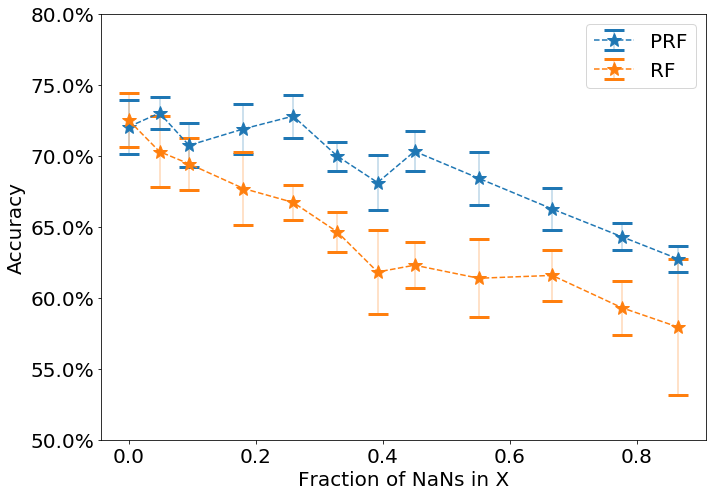

In [10]:
_ = prf_rf_nans_test_set_only_compare_full(X_train=X_train, X_test=X_test, n_itr = 10, n_trees = 1)

nan fraction:0.00, PRF:0.785, RF:0.793
nan fraction:0.05, PRF:0.785, RF:0.782
nan fraction:0.10, PRF:0.800, RF:0.766
nan fraction:0.18, PRF:0.785, RF:0.753
nan fraction:0.26, PRF:0.788, RF:0.731
nan fraction:0.33, PRF:0.766, RF:0.705
nan fraction:0.39, PRF:0.752, RF:0.700
nan fraction:0.45, PRF:0.739, RF:0.680
nan fraction:0.55, PRF:0.729, RF:0.642
nan fraction:0.67, PRF:0.696, RF:0.646
nan fraction:0.78, PRF:0.659, RF:0.613
nan fraction:0.86, PRF:0.649, RF:0.618


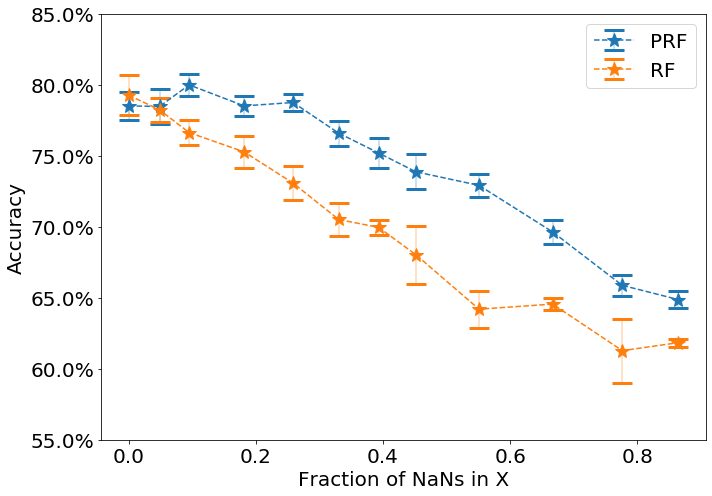

In [11]:
_ = prf_rf_nans_test_set_only_compare_full(X_train=X_train, X_test=X_test, n_itr = 5, n_trees = 10)

nan fraction:0.00, PRF:0.820, RF:0.806
nan fraction:0.05, PRF:0.804, RF:0.812
nan fraction:0.10, PRF:0.814, RF:0.772
nan fraction:0.18, PRF:0.790, RF:0.784
nan fraction:0.26, PRF:0.786, RF:0.762
nan fraction:0.33, PRF:0.776, RF:0.736
nan fraction:0.39, PRF:0.766, RF:0.722
nan fraction:0.45, PRF:0.762, RF:0.722
nan fraction:0.55, PRF:0.740, RF:0.698
nan fraction:0.67, PRF:0.728, RF:0.648
nan fraction:0.78, PRF:0.688, RF:0.630
nan fraction:0.86, PRF:0.634, RF:0.612


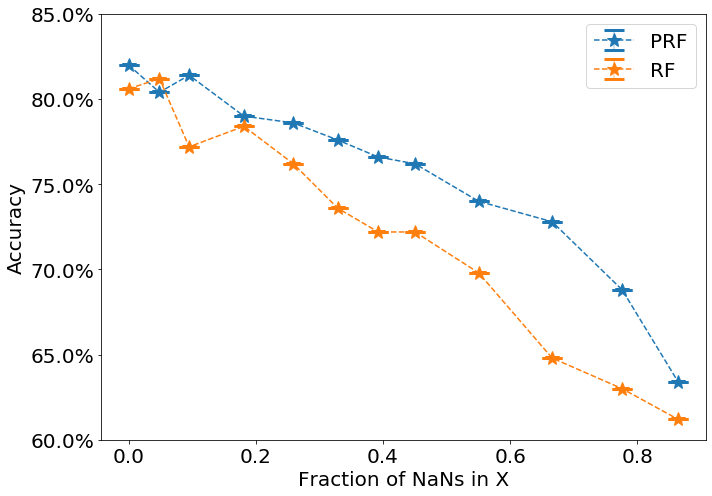

In [12]:
_ = prf_rf_nans_test_set_only_compare_full(X_train=X_train, X_test=X_test, n_itr = 1, n_trees = 25)